In [1]:
%matplotlib inline
import sys
sys.path.append('../PythonAPI')
import os
import json
from shutil import copy
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from PIL import Image
import random

In [12]:
%load_ext autoreload
%autoreload 2
from cbas import CBAS
import cbas_construction_utils as ccu
from pycocotools.coco import COCO
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the CBAS-80 and CBAS-36 datasets
* CBAS = COCO Big And Small
* Inspired by the CIFAR-100 and CIFAR-10 datasets
    * CIFAR = Canadian Institute For Advanced Research
    * CIFAR-10 and CIFAR-100 the two of the most utilized datasets in computer vision research
    * Their small image sizes (36 pixels by 36 pixels) make them managable for rapid prototyping yet more challenging than MNIST.

### Load COCO API

In [3]:
# We'll create CBAS-80 out of the COCO "train2017" image set
originSet = 'train2017'

# initialize COCO api for instance annotations and category info
coco=COCO('../annotations/instances_{}.json'.format(originSet))

loading annotations into memory...
Done (t=14.40s)
creating index...
index created!


### Display COCO categories and supercategories

In [ ]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

# Create CBAS-80
### Use COCO API to crop multiple instances out of each COCO image

CBAS-80 consists of small (3x32x32) images cropped from COCO images across all 80 categories

In [ ]:
newSet = 'cbas80' # we won't split into train/val, yet

In [ ]:
# ensure directory exists
set_directory = '../images/{}'.format(newSet)
if not os.path.exists(set_directory): 
    print('Creating new directory: ' + set_directory)
    os.makedirs(set_directory)

In [ ]:
imgIds = coco.getImgIds() # get all img ids
annIds = coco.getAnnIds() # get all ann ids

num_imgs = len(imgIds)
num_anns = len(annIds)

print("There are " + str(num_imgs) + ' images and ' + 
      str(num_anns) + ' object instances in the COCO dataset')

In [ ]:
SIZE = 32
DEDUPE = 0.25

In [ ]:
annotations = {'images':[]}

# for each image...
for j,i in enumerate(imgIds):
    coco_img = coco.loadImgs(i)[0] # load image
    img = Image.open('../images/{}/{}'.format(originSet,coco_img['file_name']))

    # Load instance annotations for this image
    annIds = coco.getAnnIds(imgIds=coco_img['id'], iscrowd=False)
    anns = coco.loadAnns(annIds)

    # Compute max-square-box for each annotation
    ccu.add_max_square_boxes(img,anns,SIZE)
    
    # Find a "gold set" of maxsquare boxes that have no significant overlap (0.5 IOU)
    gold_set_anns = ccu.dedupe_anns(anns,coco,DEDUPE)
    
    # Compute size ratios and add to annotations
    ccu.add_size_ratios(gold_set_anns,coco)
    
    # Crop cbas images and add to annotation
    ccu.add_cbas_images(img,gold_set_anns)
    
    # For each "gold set" annotation
    for g in gold_set_anns:
        
        # Create a directory string that uses the category name 
        #  - (for compatibility with pytorch's torchvision.datasets.ImageFolder data loader)
        class_directory = '../images/{}/{}'.format(newSet,str(coco.cats[g['category_id']]['name'].replace(" ", "")))

        # ensure directory exists
        if not os.path.exists(class_directory): 
            os.makedirs(class_directory)

        # Save                                 
        g['image_crop'].save('{}/{}'.format(class_directory,str(g['id'])+'.jpg'))

        # Record annotation
        annotations['images'].append({'id':g['id'], 'category_id':g['category_id'], 'size_ratio':g['size_ratio']})
         
    # Display progress
    if (j % 5000) == 0: print(str(j) + ' images complete')
        
# Report image numbers         
print(str(len(annotations['images'])) + ' images saved to ' + '../images/{}'.format(newSet))

### Create CBAS-80 annotation file
I separated this into its own cell in case something goes wrong (i.e. file path error) - you would not have to re-run the image cropping which can take a while if your doing train2017

In [ ]:
# add COCO category info to CBAS annotations dictionary
annotations['categories'] = coco.dataset['categories']
# write to file
with open('../annotations/{}.json'.format(newSet), 'w') as outfile:
    json.dump(annotations, outfile)

# Explore CBAS-80
* use statistical analysis of CBAS-80 to define the parameters of CBAS-36

In [5]:
# first load CBAS-80 annotation file
cbas80=CBAS('../annotations/{}.json'.format('cbas80'))

# Get category index so we can go from image ids to category names
idToName={}
for c in cbas80.dataset['categories']:
    idToName[str(c['id'])]=c['name']

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [6]:
cImgIds = cbas80.getImgIds() # get all img ids

num_imgs = len(cImgIds)

print("There are " + str(num_imgs) + ' images in the CBAS-80 dataset')

There are 390401 images in the CBAS-80 dataset


### Display rows of images of a given categories where size ratio progressively increases

In [10]:
SIZE=32
image_pixels = float(SIZE*SIZE)
#pixel_counts = [1.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0]
pixel_counts = [0.0,16.0,64.0,128.0,256.0,1024.0]
#pixel_counts = [0.0,16.0,128.0,1024.0]
BINS = []
for i in range(0,len(pixel_counts)-1):
    BINS.append( [ (pixel_counts[i]/image_pixels), 
                 (pixel_counts[i+1]/image_pixels) ] )
    
BINS

[[0.0, 0.015625],
 [0.015625, 0.0625],
 [0.0625, 0.125],
 [0.125, 0.25],
 [0.25, 1.0]]

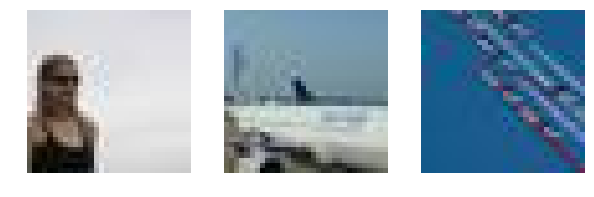

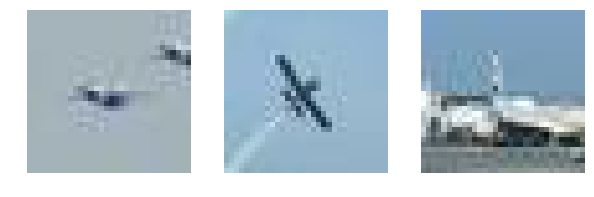

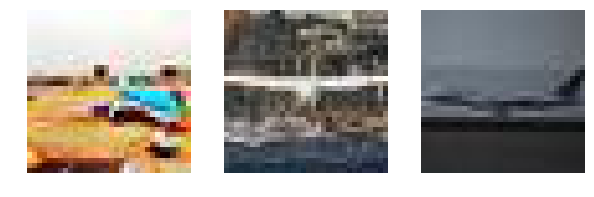

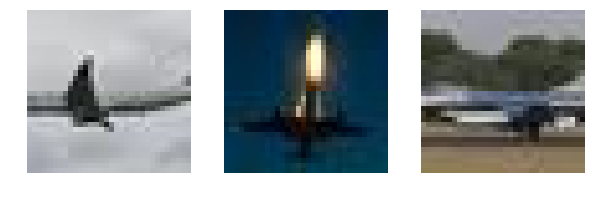

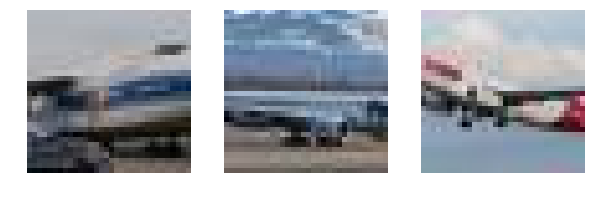

In [13]:
# get all images containing a chosen category
catIds = cbas80.getCatIds(catNms=['airplane']);

# plotting loop
for b in BINS:
    fig = plt.figure(figsize=(10,3))
    imgs = []
    
    # for each size bin, display a row of 3 random images
    imgIds = cbas80.getImgIds(catIds=catIds,szBounds=b);
    for i in range(0,3):
        cimg = cbas80.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
        imgid = str(cbas80.imgToAnns[cimg['id']][0]['category_id'])
        catstr = str(idToName[imgid].replace(" ", ""))
        class_directory = '../images/{}/{}'.format('cbas80',catstr)
        
        imgs.append(io.imread('{}/{}.jpg'.format(class_directory,cimg['id'])))
        
    sub1 = fig.add_subplot(131)
    sub1.axis('off')
    sub1.imshow(imgs[0])
    sub2 = fig.add_subplot(132)
    sub2.axis('off')
    sub2.imshow(imgs[1])
    sub3 = fig.add_subplot(133)
    sub3.axis('off')
    sub3.imshow(imgs[2])
    plt.show()

### Look at the distribution of image counts across size-ratio bins
* This is important because we ultimately want an even distribution across the size bins that we choose
    * the reason being, we want to be able to say that one size bin is easier/harder than another because of the object appearance (not because one size has more training examples)

The distribution for "person" dwarfs the other categories:


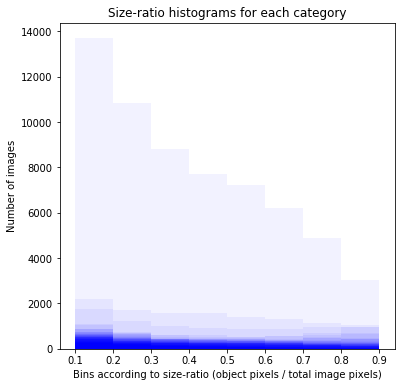

In [14]:
print('The distribution for "person" dwarfs the other categories:' )
fig = plt.figure()
ax = fig.add_subplot(111)
for t in cbas80.cats:
    sizes = []
    imgIds = cbas80.getImgIds(catIds=[t]);
    for i in imgIds:
        sizes.append(cbas80.imgToAnns[i][0]['size_ratio'])
    ax.hist(np.array(sizes), bins=np.arange(0.1, 1.0, 0.1), alpha = 0.05, color='blue')

ax.set_title("Size-ratio histograms for each category");
ax.set_xlabel('Bins according to size-ratio (object pixels / total image pixels)');
ax.set_ylabel('Number of images');

Se we zoom in:


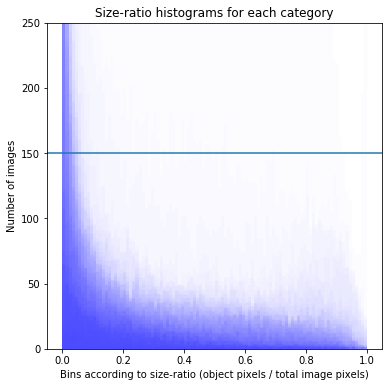

In [15]:
print('Se we zoom in:' )
fig = plt.figure()
ax = fig.add_subplot(111)
for t in cbas80.cats:
    sizes = []
    imgIds = cbas80.getImgIds(catIds=[t]);
    for i in imgIds:
        sizes.append(cbas80.imgToAnns[i][0]['size_ratio'])
    ax.hist(np.array(sizes), bins=np.arange(0.0, 1.01, 0.01), alpha = 0.01, color='blue')

ax.set_title("Size-ratio histograms for each category");
ax.set_xlabel('Bins according to size-ratio (object pixels / total image pixels)');
ax.set_ylabel('Number of images');
ax.set_ylim(0, 250); # can try some different values here
ax.axhline(y=150) # draw a line

* To make this choice easier, we can search for a minimum images-per-bin so that it maximizes the total images in our dataset with the following constraints:
    * We need at least 10 categories
    * We need at least 100 images per bin

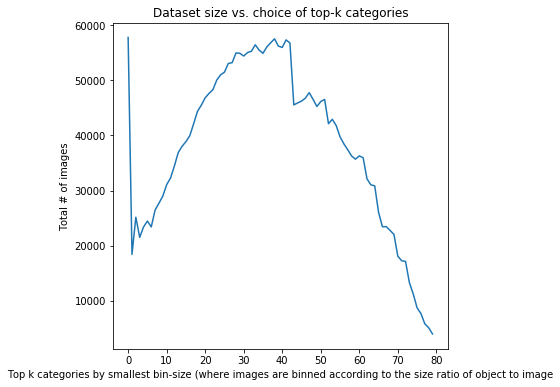

In [16]:
# Look at the minimum bin size for each category
id_counts=[]

for cat in cbas80.cats:
    bin_counts=[]
    for b in BINS:
        bin_counts.append(len(cbas80.getImgIds(catIds=[cat], szBounds=b)))
    id_counts.append([cat,min(bin_counts)])
    #print(bin_counts)
    #print()
    
binmins = sorted(id_counts,key=lambda l:l[1], reverse=True)#[0:36]

total_imgs=[]
for i,b in enumerate(binmins):
    #total_imgs.appen(idToName[str(b[0])] + ': min:' + str(b[1]) + ' total images:' + str(b[1]*8*(i+1)))
    total_imgs.append(b[1]*len(BINS)*(i+1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_imgs)
ax.set_title("Dataset size vs. choice of top-k categories");
ax.set_xlabel('Top k categories by smallest bin-size (where images are binned according to the size ratio of object to image' );
ax.set_ylabel('Total # of images');

In [ ]:
binmins[34:]

# Create CBAS-34
* randomly select a subset of images from CBAS-80 and copy them into a new (CBAS-34) directory

In [ ]:
newSet2 = 'cbas34'

In [17]:
if not cbas80: # prob already loaded this
    cbas80=CBAS('../annotations/{}.json'.format(newSet))

# Get category index so we can go from image ids to category names
if not idToName:
    idToName={}
    for c in cbas80.dataset['categories']:
        idToName[str(c['id'])]=c['name']

In [19]:
# Get top 34 categories according to min(image counts across size bins)
#  - i.e. we want the categories that have the largest min counts because that means ...
#  - we can have an even distribution of examples across size bins
id_counts=[]

for cat in cbas80.cats:
    bin_counts=[]
    for b in BINS:
        bin_counts.append(len(cbas80.getImgIds(catIds=[cat], szBounds=b)))
    id_counts.append([cat,min(bin_counts)])
    
categories_descending = sorted(id_counts,key=lambda l:l[1], reverse=True)
top34 = categories_descending[:34]
next34 = categories_descending[34:68]

In [ ]:
for t in top34:
    # randomly select 332 images from each size bin
    imgIds={}
    imgIds['train'] = []
    imgIds['val'] = []
    for szbin in BINS:
        theseImgIds = cbas80.getImgIds(catIds=t[0],szBounds=szbin)
        rand_selection = np.random.choice(theseImgIds, size=332, replace=False)
        imgIds['train'] += rand_selection.tolist()[:300]
        imgIds['val'] += rand_selection.tolist()[300:]
        
    for dType in ['train', 'val']:
        # copy over each image to new folder
        for i in imgIds[dType]:
            # Get category string with no spaces for folder paths
            catstr = str(idToName[str(t[0])].replace(" ", ""))

            src = '../images/{}/{}/{}.jpg'.format(newSet,catstr,i)

            class_directory = '../images/{}_{}/{}'.format(newSet2,dType,catstr)

            # Ensure destination directory exists
            if not os.path.exists(class_directory):
                            os.makedirs(class_directory)

            dst = '{}/{}.jpg'.format(class_directory,i)
            
            copy(src,dst)
            
print('Finished copying images into {}'.format('../images/{}'.format(newSet2)))

If that worked, you can try running the training demo notebook

# Create CBAS-LS

In [ ]:
newSet = 'cbas80'
newSet2 = 'cbas34'
newSet3 = 'cbasLS'

In [ ]:
for t in next34:
    # randomly select 69 images from each size bin
    imgIds={}
    imgIds['train'] = []
    imgIds['val'] = []
    for szbin in BINS:
        theseImgIds = cbas80.getImgIds(catIds=t[0],szBounds=szbin)
        rand_selection = np.random.choice(theseImgIds, size=69, replace=False)
        imgIds['train'] += rand_selection.tolist()[:20]
        imgIds['val'] += rand_selection.tolist()[20:]
        
    for dType in ['train', 'val']:
        # copy over each image to new folder
        for i in imgIds[dType]:
            # Get category string with no spaces for folder paths
            catstr = str(idToName[str(t[0])].replace(" ", ""))

            src = '../images/{}/{}/{}.jpg'.format(newSet,catstr,i)

            class_directory = '../images/{}_{}/{}'.format(newSet2,dType,catstr)

            # Ensure destination directory exists
            if not os.path.exists(class_directory):
                            os.makedirs(class_directory)

            dst = '{}/{}.jpg'.format(class_directory,i)
            
            copy(src,dst)
            
print('Finished copying images into {}'.format('../images/{}'.format(newSet2)))